In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
# Load the dataset 
df = pd.read_csv('Rossman_sales_project.csv')

# Display sample of five rows
print("Sample of 5 rows:")
df.head()

Sample of 5 rows:


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
# Check the shape of the data
print(f"Dataset shape: {df.shape}")
print("\nDataset info:")
df.info()

Dataset shape: (1017209, 9)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [38]:
# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Convert 'StateHoliday' to categorical
df['StateHoliday'] = df['StateHoliday'].astype('category')

# Extract time-based features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
df['DayOfYear'] = df['Date'].dt.dayofyear
df['IsMonthEnd'] = df['Date'].dt.is_month_end.astype(int)
df['IsMonthStart'] = df['Date'].dt.is_month_start.astype(int)

# Check the updated info
print(df.info())


KeyError: 'Date'

In [ ]:
# Check percentage of missing values in each column
print("Missing values percentage:")
missing_percent = (df.isnull().sum() / len(df)) * 100
print(missing_percent[missing_percent > 0])

# Drop missing values if any
df = df.dropna()
print(f"\nShape after dropping missing values: {df.shape}")

In [6]:
# Check and remove duplicate rows
print(f"Number of duplicate rows: {df.duplicated().sum()}")
df = df.drop_duplicates()
print(f"Shape after removing duplicates: {df.shape}")

Number of duplicate rows: 0
Shape after removing duplicates: (1017209, 9)


In [7]:
# Convert StateHoliday to numeric
# Assuming StateHoliday has values like '0', 'a', 'b', 'c'
df['StateHoliday'] = df['StateHoliday'].map({'0': 0, 'a': 1, 'b': 2, 'c': 3}).fillna(0)

# Convert to numeric type
df['StateHoliday'] = pd.to_numeric(df['StateHoliday'], errors='coerce')

In [8]:
# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Create recency feature
end_date = df['Date'].max()
df['Recency'] = (end_date - df['Date']).dt.days

# Drop Date and Store columns as requested
df = df.drop(['Date', 'Store'], axis=1)

print("Dataset after feature engineering:")
df.head()

Dataset after feature engineering:


,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Recency
0,5,5263,555,1,1,0.0,1,0
1,5,6064,625,1,1,0.0,1,0
2,5,8314,821,1,1,0.0,1,0
3,5,13995,1498,1,1,0.0,1,0
4,5,4822,559,1,1,0.0,1,0


In [9]:
# Basic statistics
print("Basic statistics:")
df.describe()

Basic statistics:


,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Recency
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,4.516279e-02,1.786467e-01,4.759370e+02
std,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,2.836559e-01,3.830564e-01,2.744541e+02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.310000e+02
50%,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.850000e+02
75%,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,7.130000e+02
max,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,3.000000e+00,1.000000e+00,9.410000e+02


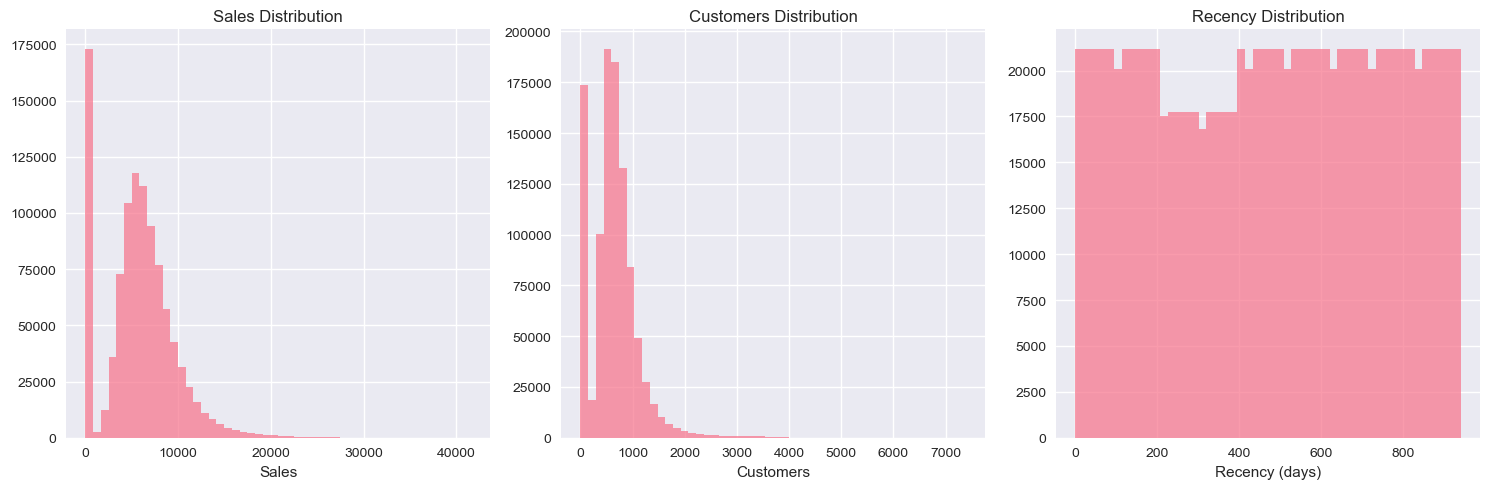

In [10]:
# Visualize distribution of Sales, Customers, and Recency
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(df['Sales'], bins=50, alpha=0.7)
axes[0].set_title('Sales Distribution')
axes[0].set_xlabel('Sales')

axes[1].hist(df['Customers'], bins=50, alpha=0.7)
axes[1].set_title('Customers Distribution')
axes[1].set_xlabel('Customers')

axes[2].hist(df['Recency'], bins=50, alpha=0.7)
axes[2].set_title('Recency Distribution')
axes[2].set_xlabel('Recency (days)')

plt.tight_layout()
plt.show()

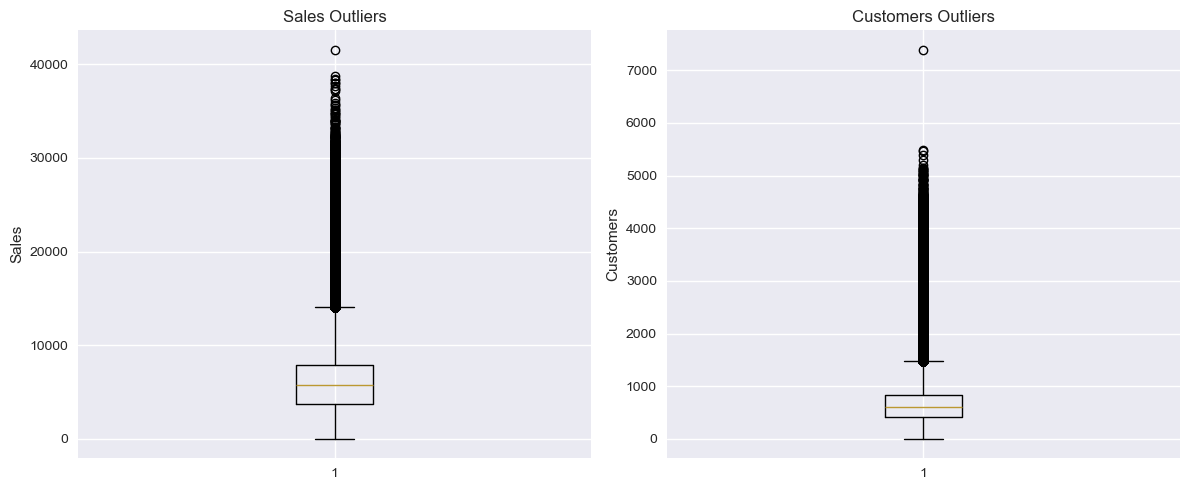

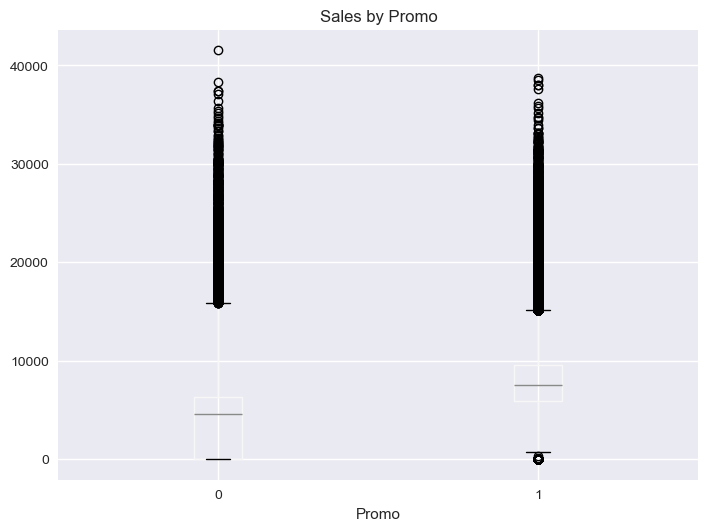

In [11]:
# Box plots for outliers in Sales and Customers
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Box plot for Sales
axes[0].boxplot(df['Sales'])
axes[0].set_title('Sales Outliers')
axes[0].set_ylabel('Sales')

# Box plot for Customers
axes[1].boxplot(df['Customers'])
axes[1].set_title('Customers Outliers')
axes[1].set_ylabel('Customers')

plt.tight_layout()
plt.show()

# Check if promo affects Sales
plt.figure(figsize=(8, 6))
df.boxplot(column='Sales', by='Promo', ax=plt.gca())
plt.title('Sales by Promo')
plt.suptitle('')  # Remove default title
plt.show()

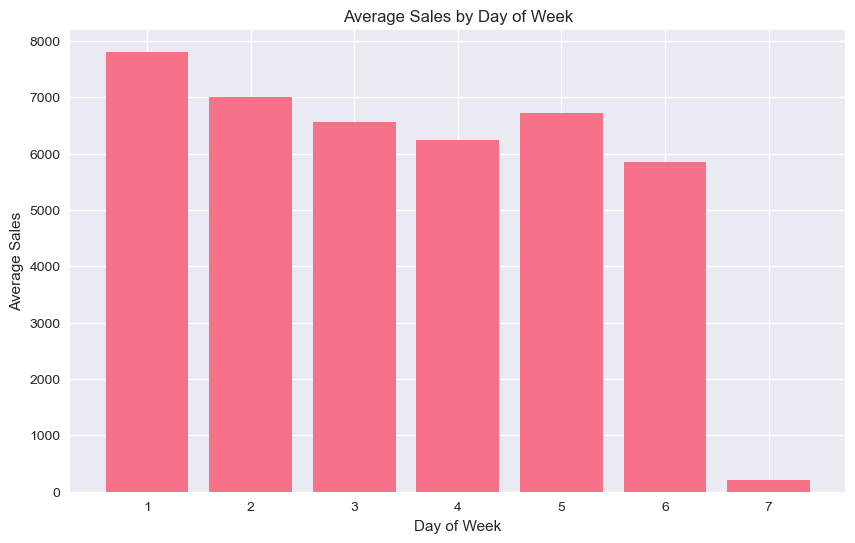

In [12]:
# Visualize if DayOfWeek affects Sales
plt.figure(figsize=(10, 6))
day_sales = df.groupby('DayOfWeek')['Sales'].mean()
plt.bar(day_sales.index, day_sales.values)
plt.title('Average Sales by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Sales')
plt.show()

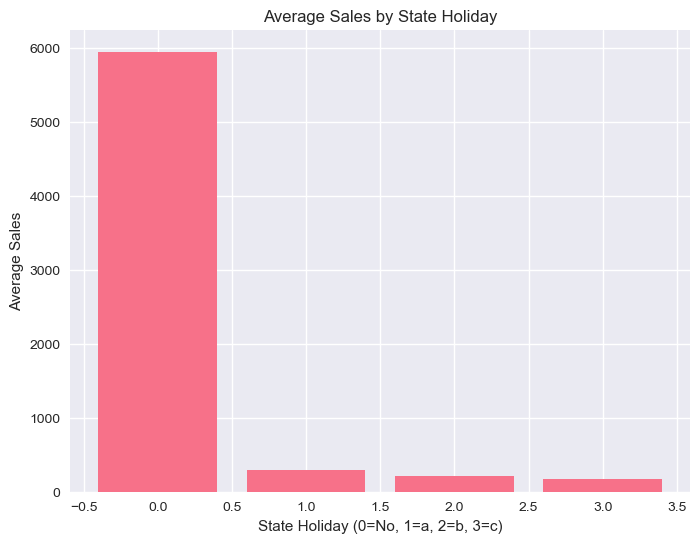

In [13]:
# Visualize if State holidays affect Sales
plt.figure(figsize=(8, 6))
state_holiday_sales = df.groupby('StateHoliday')['Sales'].mean()
plt.bar(state_holiday_sales.index, state_holiday_sales.values)
plt.title('Average Sales by State Holiday')
plt.xlabel('State Holiday (0=No, 1=a, 2=b, 3=c)')
plt.ylabel('Average Sales')
plt.show()

In [14]:
# Remove instances having Sales > 20000
print(f"Shape before removing high sales: {df.shape}")
df = df[df['Sales'] <= 20000]
print(f"Shape after removing high sales: {df.shape}")

# Handle outliers in Customers column using IQR method
Q1 = df['Customers'].quantile(0.25)
Q3 = df['Customers'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Removing customers outliers below {lower_bound} and above {upper_bound}")
df = df[(df['Customers'] >= lower_bound) & (df['Customers'] <= upper_bound)]
print(f"Final shape after outlier handling: {df.shape}")

Shape before removing high sales: (1017209, 8)
Shape after removing high sales: (1013110, 8)
Removing customers outliers below -243.5 and above 1480.5
Final shape after outlier handling: (978389, 8)


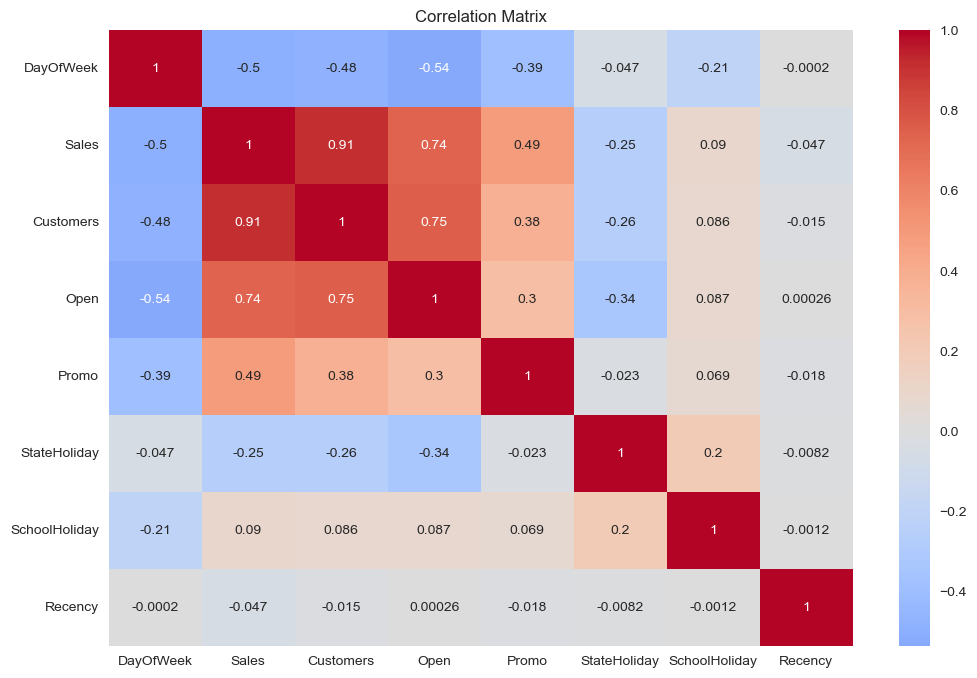

Correlation with Sales:
Sales            1.000000
Customers        0.910513
Open             0.741098
Promo            0.486337
SchoolHoliday    0.089998
Recency         -0.046690
StateHoliday    -0.254187
DayOfWeek       -0.503971
Name: Sales, dtype: float64


In [15]:
# Check correlation among features
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

# Print correlation with Sales
print("Correlation with Sales:")
sales_corr = df.corr()['Sales'].sort_values(ascending=False)
print(sales_corr)

In [16]:
# Store target column (Sales) in y variable and rest in X variable
y = df['Sales']
X = df.drop('Sales', axis=1)

# Split the dataset into 70% training and 30% testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

Training set size: (684872, 7)
Testing set size: (293517, 7)


In [ ]:
# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    
    print(f"\n{model_name} Results:")
    print(f"Training RMSE: {train_rmse:.2f}")
    print(f"Testing RMSE: {test_rmse:.2f}")
    print(f"Training MAE: {train_mae:.2f}")
    print(f"Testing MAE: {test_mae:.2f}")
    
    return model, test_rmse, test_mae

In [ ]:
# Train a Decision Tree model
dt_model = DecisionTreeRegressor(random_state=42)
dt_model, dt_rmse, dt_mae = evaluate_model(dt_model, X_train, X_test, y_train, y_test, "Decision Tree")

# Check feature importance from Decision Tree
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nDecision Tree Feature Importance:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.title('Top 10 Feature Importances - Decision Tree')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Train multiple Decision Tree models with different parameters
max_depths = [5, 10, 15, 20, None]
max_features_options = ['sqrt', 'log2', None]

best_dt_rmse = float('inf')
best_dt_params = {}

print("Testing different Decision Tree parameters:")
for depth in max_depths:
    for features in max_features_options:
        dt = DecisionTreeRegressor(
            max_depth=depth,
            max_features=features,
            random_state=42
        )
        
        dt.fit(X_train, y_train)
        y_pred = dt.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        print(f"Max Depth: {depth}, Max Features: {features}, RMSE: {rmse:.2f}")
        
        if rmse < best_dt_rmse:
            best_dt_rmse = rmse
            best_dt_params = {'max_depth': depth, 'max_features': features}

print(f"\nBest Decision Tree parameters: {best_dt_params}")
print(f"Best Decision Tree RMSE: {best_dt_rmse:.2f}")


Random Forest Results:
Training RMSE: 703.51
Testing RMSE: 1325.56
Training MAE: 466.62
Testing MAE: 906.58

Random Forest Feature Importance:
         feature  importance
1      Customers    0.911150
6        Recency    0.043566
3          Promo    0.026635
0      DayOfWeek    0.014365
5  SchoolHoliday    0.004171
4   StateHoliday    0.000112
2           Open    0.000000


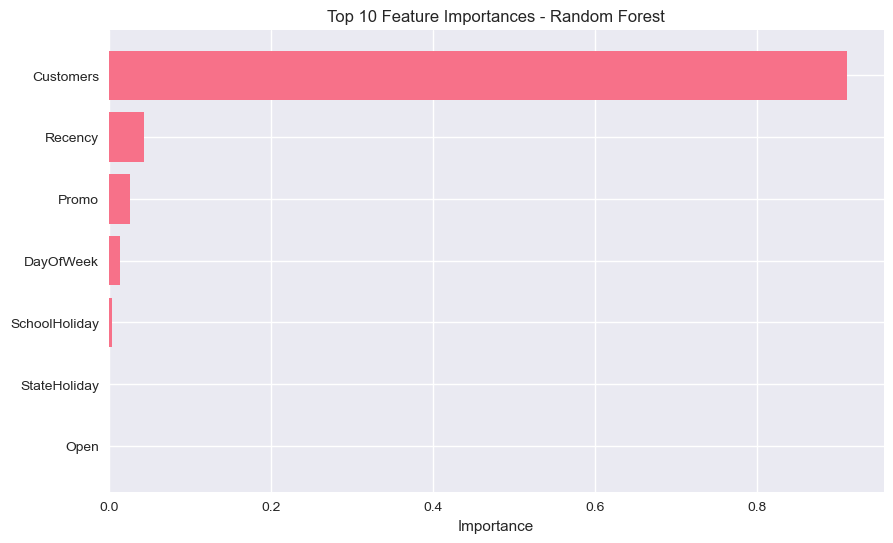

In [30]:
# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model, rf_rmse, rf_mae = evaluate_model(rf_model, X_train, X_test, y_train, y_test, "Random Forest")

# Feature importance from Random Forest
rf_feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nRandom Forest Feature Importance:")
print(rf_feature_importance.head(10))

# Plot Random Forest feature importance
plt.figure(figsize=(10, 6))
plt.barh(rf_feature_importance['feature'][:10], rf_feature_importance['importance'][:10])
plt.title('Top 10 Feature Importances - Random Forest')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.show()

In [31]:
# Train an AdaBoost Regressor model
ada_model = AdaBoostRegressor(n_estimators=100, random_state=42)
ada_model, ada_rmse, ada_mae = evaluate_model(ada_model, X_train, X_test, y_train, y_test, "AdaBoost")


AdaBoost Results:
Training RMSE: 1369.68
Testing RMSE: 1374.42
Training MAE: 975.51
Testing MAE: 978.68


In [32]:
# Train a Stacking Regressor model
# Base models
base_models = [
    ('dt', DecisionTreeRegressor(max_depth=10, random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=50, random_state=42)),
    ('ada', AdaBoostRegressor(n_estimators=50, random_state=42))
]

# Stacking model with Linear Regression as meta-learner
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=LinearRegression(),
    cv=5
)

stacking_model, stacking_rmse, stacking_mae = evaluate_model(
    stacking_model, X_train, X_test, y_train, y_test, "Stacking"
)


Stacking Results:
Training RMSE: 1075.27
Testing RMSE: 1196.40
Training MAE: 738.74
Testing MAE: 821.33



Model Comparison:
           Model         RMSE          MAE
3       Stacking  1196.397886   821.325831
1  Random Forest  1325.556837   906.583600
2       AdaBoost  1374.415977   978.681494
0  Decision Tree  1588.353366  1074.351358


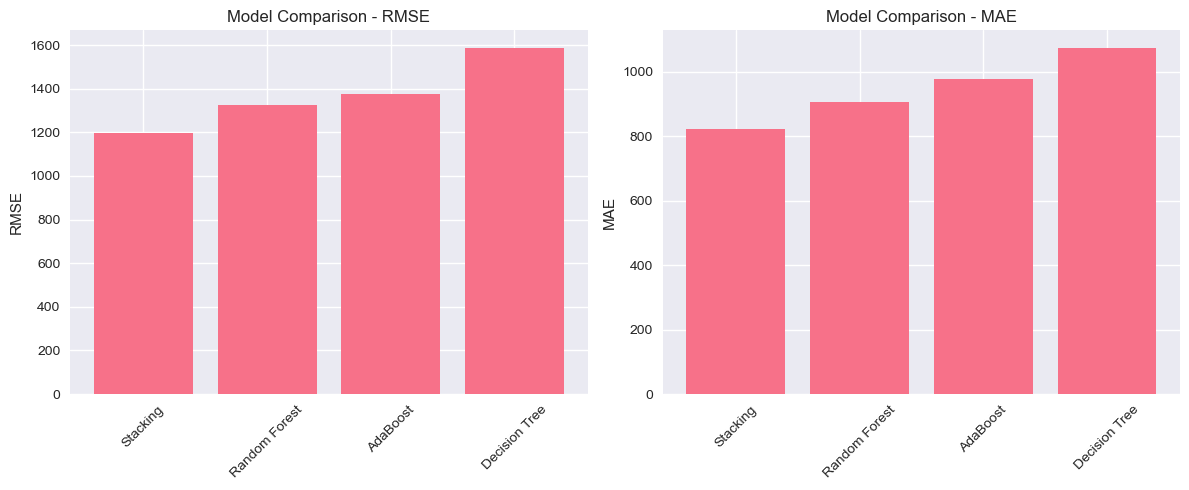

In [33]:
# Compare all models
models_comparison = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'AdaBoost', 'Stacking'],
    'RMSE': [dt_rmse, rf_rmse, ada_rmse, stacking_rmse],
    'MAE': [dt_mae, rf_mae, ada_mae, stacking_mae]
}).sort_values('RMSE')

print("\nModel Comparison:")
print(models_comparison)

# Plot model comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(models_comparison['Model'], models_comparison['RMSE'])
plt.title('Model Comparison - RMSE')
plt.ylabel('RMSE')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(models_comparison['Model'], models_comparison['MAE'])
plt.title('Model Comparison - MAE')
plt.ylabel('MAE')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [34]:
# Summary and insights
print("="*50)
print("ASSIGNMENT SUMMARY")
print("="*50)

print(f"\n1. Best performing model: {models_comparison.iloc[0]['Model']}")
print(f"   RMSE: {models_comparison.iloc[0]['RMSE']:.2f}")
print(f"   MAE: {models_comparison.iloc[0]['MAE']:.2f}")

print(f"\n2. Key features affecting sales (based on Random Forest):")
for i, row in rf_feature_importance.head(5).iterrows():
    print(f"   - {row['feature']}: {row['importance']:.3f}")

print(f"\n3. Data preprocessing:")
print(f"   - Original dataset shape: {df.shape}")
print(f"   - Final dataset shape after cleaning: {X.shape}")
print(f"   - Training set size: {X_train.shape[0]} samples")
print(f"   - Test set size: {X_test.shape[0]} samples")

print(f"\n4. Model performance ranking:")
for i, row in models_comparison.iterrows():
    print(f"   {i+1}. {row['Model']}: RMSE = {row['RMSE']:.2f}, MAE = {row['MAE']:.2f}")

ASSIGNMENT SUMMARY

1. Best performing model: Stacking
   RMSE: 1196.40
   MAE: 821.33

2. Key features affecting sales (based on Random Forest):
   - Customers: 0.911
   - Recency: 0.044
   - Promo: 0.027
   - DayOfWeek: 0.014
   - SchoolHoliday: 0.004

3. Data preprocessing:
   - Original dataset shape: (978389, 8)
   - Final dataset shape after cleaning: (978389, 7)
   - Training set size: 684872 samples
   - Test set size: 293517 samples

4. Model performance ranking:
   4. Stacking: RMSE = 1196.40, MAE = 821.33
   2. Random Forest: RMSE = 1325.56, MAE = 906.58
   3. AdaBoost: RMSE = 1374.42, MAE = 978.68
   1. Decision Tree: RMSE = 1588.35, MAE = 1074.35
